In [1]:
# Data manipulation
import datetime as dt 
import pandas as pd 
import numpy as np 
import time
import re
import io

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Chess
import chess.svg
import chess.pgn
import stockfish
from stockfish import Stockfish 

# Scraping
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By 
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

1. Distribution of players wade_59405 has played against, sorted histogram of counts of games played
2. Same as #1 but duration of chess played instead of # of games
3. 20 great moves made by wade_59405 (can use chess.com's "Great" move guide or it can be a move that has an eval change of more than 2 in a depth of three or more moves)
4. 20 Brilliant moves made by wade_59405 (can use chess.com's "Brilliant" move guide or it can be a move that has an eval change of more than 2 in a depth of five or more moves)
5. 10 funny moves. Unusual moves that worked or didn't work
6. Bonus work: 10 traps. I'm not sure how to find these, but if you can find 5 traps Wade made and 5 traps Wade was put in, I'll add an additional milestone payment to the job. We can discuss the details of this if you are interested.
For #3 and #4, you can either parse the chess.com analysis for "brilliant" or "great move", or you can probably run a local stockfish analysis and look for big shifts in eval. You'll probably have to do something with a minimum depth so that this filters out blunders.

Positions breakdown for #3 and #4
- 25% (5) non-mates against mckkcm001
- 25% (5) mates against mckkcm001
- 12% (3) non-mates against maxgood
- 12% (2) mates against maxgood
- 12% (3) non-mates anyone
- 12% (2) mates anyone

## Building the dataframe

In [2]:
def parse_pgn(pgn_path):   
    '''Create a proper dataframe from a chess.com PGN file. Returns a dataframe with every opponents , and another without the bots.'''

    # Load data
    pgn = open(pgn_path , "r")
    raw = pgn.readlines()

    # Patterns
    event = re.compile("\\[Event(.*?)\\]")
    date = re.compile("\\[Date(.*?)\\]")
    white = re.compile("\\[White (.*?)\\]")
    black = re.compile("\\[Black (.*?)\\]")
    result = re.compile("\\[Result(.*?)\\]")
    position = re.compile("\\[CurrentPosition(.*?)\\]")
    utc_date = re.compile("\\[UTCDate(.*?)\\]")
    time_ = re.compile("\\[UTCTime(.*?)\\]")
    white_elo = re.compile("\\[WhiteElo(.*?)\\]")
    black_elo = re.compile("\\[BlackElo(.*?)\\]")
    time_control = re.compile("\\[TimeControl(.*?)\\]")
    termination = re.compile("\\[Termination(.*?)\\]")
    end_date = re.compile("\\[EndDate(.*?)\\]")
    end_time = re.compile("\\[EndTime(.*?)\\]")
    link = re.compile("\\[Link(.*?)\\]")


    # Get the lists
    columns = ['Event' , 'Date' , 'White' , 'Black' , 'Result' , 'Position'  , 'Utc_date' , 'Time' , 'White_elo' , 'Black_elo' , 'Time_control' , 'Terminaison' , 'End_date' , 'End_time' , 'Link']
    list_patterns = [event , date , white , black , result , position  , utc_date , time_ , white_elo , black_elo , time_control , termination , end_date , end_time , link]
    assert len(columns) == len(list_patterns)

    # Turn the data into a dict
    to_df = {}
    for i in range(len(columns)):
        data = re.findall(pattern=list_patterns[i] , string=str(raw))
        to_df[columns[i]] = data 

    # Turn the data into a pandas dataframe
    df = pd.DataFrame(to_df)

    # A bit of cleaning
    for col in df:
        df[col] = df[col].apply(lambda x : str(x).replace('"' , ''))

    # Get the games
    game = re.compile("\\[Link(.*?\\d-\\d)")
    games = re.findall(pattern=game , string=str(raw))

    # Clean the appended games
    pattern = re.compile("https://(.*?)'\\d")
    clean_games = []
    for game in games:
        cleaned = re.sub(pattern=pattern , repl='1' , string=str(game))
        game_ = cleaned.replace('"' , '').lstrip()
        clean_games.append(re.sub(pattern=pattern , repl='1' , string=game_))

    # Add the games position
    df['game'] = clean_games 

    white = list(df['White'].unique())
    black = list(df['Black'].unique())
    white.extend(black)
    opponent_list = [op for op in white if op != 'wade_59405']

    # Find the bots
    bots = []
    for name in opponent_list:
        if str(name).startswith('Computer'):
            bots.append(name)
        if str(name).endswith('BOT'):
            bots.append(name)

    # Remove bots and Computers
    without_bot_df = df[(df['White'].isin(bots) == False) & (df['Black'].isin(bots) == False)].reset_index(drop=True)

    return df , without_bot_df

In [3]:
df , without_bot_df = parse_pgn("C:\\Users\\lucas\\OneDrive\\Bureau\\Code\\Python\\DATACAMP\\Projets\\freelance\\chess_analyse\\games.pgn")

## Count bar of the opponents

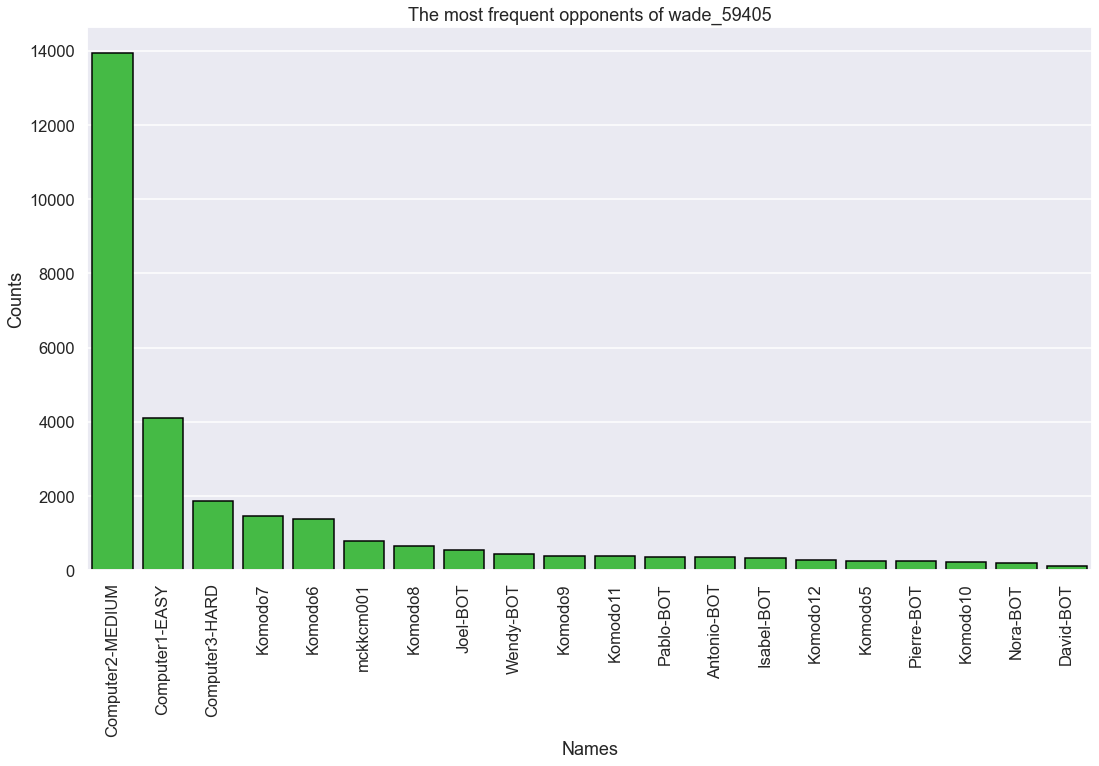

In [4]:
def opponent_count_plot(df_ : pd.DataFrame , save_or_not : bool):  
    '''Create a sorted countplot of wade's favorite opponents'''

    b_op = [op for op in list(df_['Black']) if op != 'wade_59405']
    w_op = [op for op in list(df_['White']) if op != 'wade_59405']
    b_op.extend(w_op)
    to_count = np.unique(b_op)

    names = []
    counts = []
    for i in range(len(to_count)):
        names.append(to_count[i])
        counts.append(b_op.count(to_count[i]))

    to_plot = pd.DataFrame({'Names' : names , 'Counts' : counts}).nlargest(columns='Counts' , n=20)

    sns.set_style('darkgrid')
    with sns.plotting_context('talk'):
        plt.figure(figsize=(18,10))
        sns.barplot(x=to_plot['Names'] , y=to_plot['Counts'] , edgecolor='black' , color='limegreen')
        plt.xticks(rotation=90)
        plt.title('The most frequent opponents of wade_59405')
        if save_or_not == True:
            plt.savefig('Countplot_opponents' , dpi=300, bbox_inches='tight')
        plt.show()


opponent_count_plot(df_=df , save_or_not=False)

## Count bar of the times controls

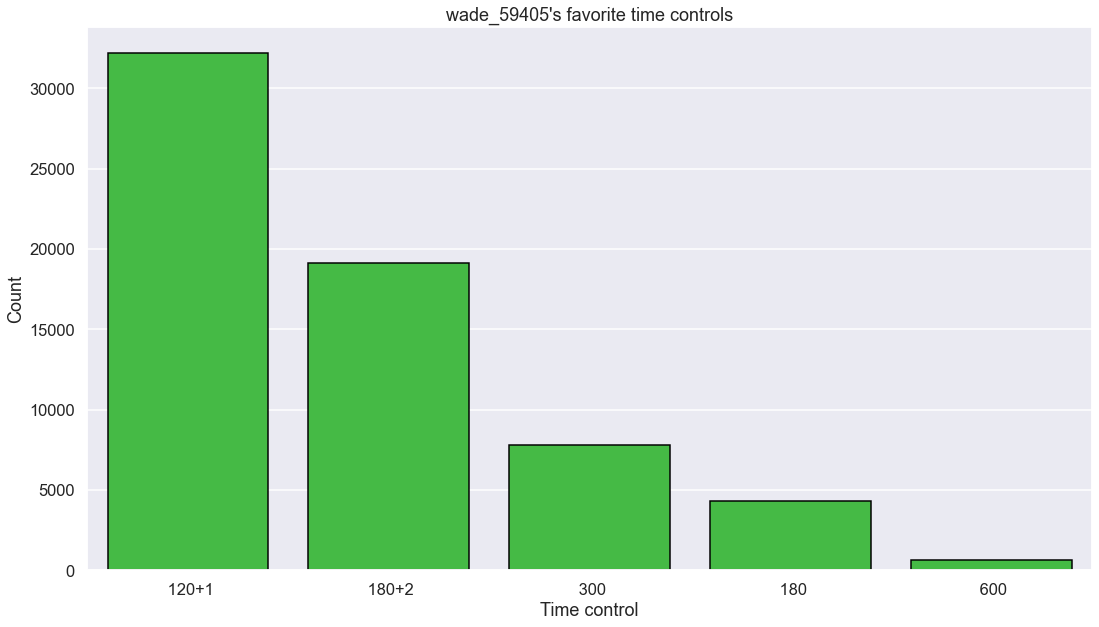

In [5]:
def countplot_duration(df_ : pd.DataFrame , save_or_not : bool):   
    '''Return a sorted countplot of wade's favorite times control'''
    
    to_plot = df_.groupby('Time_control')['White'].count().sort_values(ascending=False).head(5)
    with sns.plotting_context('talk'):
        plt.figure(figsize=(18,10))
        sns.barplot(x=to_plot.index , y=to_plot.values , edgecolor='black' , color='limegreen')
        plt.ylabel('Count')
        plt.xlabel('Time control')
        plt.title("wade_59405's favorite time controls")
        if save_or_not == True:
            plt.savefig('Countplot_time_control' ,  dpi=300, bbox_inches='tight')
        plt.show()

countplot_duration(df_=df , save_or_not=False)

# Find the moves

In [6]:
def find_great_moves(depth : int , range_ : int , df=df , path_="C:\\Program Files (x86)\\stockfish_15.1_win_x64_avx2\\stockfish-windows-2022-x86-64-avx2.exe"):
    '''Returns a dataframe with important moves made by wade on the white side ,
    an another for the black side , a dataframe with the traps , and one with all the moves.
    You need to have stockfish installed to reproduce / use this function (see this link for the pip stockfish doc: https://pypi.org/project/stockfish)'''

    ########## Constants ##########
    stock = Stockfish(path=path_ , depth=depth)
    mate_dict = {0 : 32765 , -0 : -32765,
                1 : 31765 , -1 : -31765,
                2 : 30765 , -2 : -30765,
                3 : 29765 , -3 : -29765,
                4 : 28765 , -4 : -28765,
                5 : 27765 , -5 : -27765,
                6 : 26765 , -6 : -26765,
                7 : 25765 , -7 : -25765,
                8 : 24765 , -8 : -24765,
                9 : 23765 ,  -9 : -23765,
                10 : 22765 , -10 : -22765}
    trap_dict  = {'r2qkbnr/3b1ppp/p2p4/1p1Q4/2p1P3/1B6/PPP2PPP/RNB1K2R w KQkq - 0 12':"Noah's Ark Trap",
            'r2q1bnr/ppp1kBpp/2np4/3NN3/4P3/7P/PPPP1PP1/R1BbK2R b KQ - 2 8':"Legal Trap" , 
            'r1bqk1nr/ppp2ppp/2np4/8/1bBPP3/5N2/PP3PPP/RNBQK2R w KQkq - 1 7': "Italian Belloni Trap",
            'r1b1kbnr/pppp1ppp/2n5/4P3/8/5N2/PqPBPPPP/RN1QKB1R w KQkq - 0 6':"Englund Gambit Trap",
            'r1bqkb1r/pppp1pp1/2n5/1B2p2p/4P1n1/5N1P/PPPP1PP1/RNBQ1RK1 w kq - 0 6':"Fishing Pole Trap",
            'rnb1k1nr/ppp2ppp/8/4P3/1BP4q/8/PP4PP/RN1QKBnR w kq - 2 9':"Lasker Trap",
            "rnbqkbnr/pppp1ppp/8/8/2B1P3/8/PB3PPP/RN1QK1NR b KQkq - 0 5":"Danish Bird Trap",
            "r2qk2r/2pp1ppp/ppn5/1Qn1P3/2P5/5N2/PP1NPPPP/R3KB1R w KQkq - 0 11":"Tricky Mate Trap (Faja)",
            'r1bq1bkr/pppp2pp/2n5/4p1N1/8/5Q2/PPPP1PPP/R1B1K1NR b KQ - 4 7':"Trap in the Vienna",
            "r1bk3r/pppn1ppp/8/3n4/1b1P4/8/PP1QPPPP/R3KBNR w KQ - 0 9":"Elephant trap",
            'r1bk3r/pppn1ppp/8/3n4/1b1P4/8/PP1QPPPP/R3KBNR w KQ - 0 9':"Kieniger trap",
            'r1bk3r/pppn1ppp/8/3n4/1b1P4/8/PP1QPPPP/R3KBNR w KQ - 0 9':"Blackburn chilling trap",
            'r1b1kb1r/ppqp1ppp/4p3/8/2B1P1P1/5N2/PP2NPP1/R1B2RK1 b kq - 0 11' : 'Siberian trap',
            'rn1qkb1r/pp1bpp1p/3p2p1/1B6/3NP1Q1/2N1B3/PPP2PPP/R3K2R b KQkq - 0 8' : 'Valt vs Albert',
            'r2q1bnr/ppp1kBpp/3p4/3NN3/4P3/8/PP3PPP/R1Bb1RK1 b - - 2 10' : 'Legal Scotch Gambit',
            'rnbqkb1r/pp2pBpp/5n2/4p3/8/2N5/PP3PPP/R1BQK1NR b KQkq - 0 7' : 'David vs Anthony',
            'r1bqr1k1/1pBnb1pp/p7/3p1p2/3Pn3/3BPN2/PPQ2PPP/2R2RK1 b - - 1 14' :'Rubinstein',
            'rnbqk1nr/ppp2p1p/8/6p1/8/5NbP/PPPPP1P1/RNBQKB1R w KQkq - 1 6' : 'Kova vs Toxe',
            'rnb1kb1r/pppp1ppp/8/4P3/7q/4P1PP/PPPNP3/R1BQKBNR b KQkq - 0 6' : 'Budapest trap',
            'r1bqkb1r/p2p1ppp/2p2nn1/1p6/B1N1P3/3P4/PPP2PPP/RNBQK2R w KQkq - 0 8' : 'Mortimer trap',
            'rnbqk2r/ppp2ppp/8/8/2P5/P5b1/1P2PK1P/RNBQ1BNR w kq - 0 8' : 'Warren vs Jack selman',
            'rn2k1nr/ppp2p1p/3P4/8/3q2b1/5KP1/PPPP3P/RNBQ1B1R w kq - 1 11' : 'From gambit',
            'rnb1kbnr/pppp1ppp/8/4p3/6Pq/5P2/PPPPP2P/RNBQKBNR w KQkq - 1 3' : 'Fool mate',
            'rnb1kbnQ/ppppqp1p/6p1/8/4P3/8/PPPP1PPP/RNB1KBNR b KQq - 0 4' : 'Queen raid  , scholar mate',
            'rn2kb1r/ppN1pppp/5n2/8/1q6/4Bb2/PPP3PP/2KR1BNR b kq - 0 9' : 'Halosar trap',
            'rnb1kb1r/ppNp1pp1/6np/2p5/q6B/2P5/PP2PPPP/R3KBNR b KQkq - 1 9' : 'Tate bennoni',
            'rnbqk1nr/ppp2p1p/8/6p1/8/5NbP/PPPPP1P1/RNBQKB1R w KQkq - 1 6':'Bird trap',
            'rnbk1Qnr/pppp2pp/8/8/2B1P2q/8/PPPPK2P/RNB3Nq b - - 0 8' : 'King gambit , bishop trap',
            'rnb1kbnr/pppp1ppp/8/8/4q3/1P5P/P1PP1K2/RNBQ1BNn w kq - 0 8' : 'King gambit , goez trap',
            'r2Bk2r/ppp2ppp/2p5/8/4n1b1/3P4/PPP1KbPP/RN1Q1B1R w kq - 2 9' : 'Staford Gambit trap',
            '3k2nr/ppN2ppp/8/4B3/1b1n4/8/PPb2PPP/R3KB1R w KQ - 1 12' : 'Nimzo defense trap',
            'rn2k2r/pp3ppp/5p2/5Q2/1b6/8/P1p1PPPP/R3KBNR w KQkq - 0 13' : 'Richter attack',
            'r1bq1k1r/ppppnp1p/5NpB/8/3nP3/8/PPP2PPP/R3KB1R b KQ - 3 10' : 'Three knight game trap',
            '2kr2nr/ppp2ppp/2n5/4P3/2P3bq/2B5/PP1K2PP/RN2QBnR w - - 8 12' : 'Lasker trap',
            'r1bqkb1r/pp1npppp/2pN1n2/8/3P4/8/PPP1QPPP/R1B1KBNR b KQkq - 4 6' : 'Alekine caro khan trap',
            'r1bQ1b1r/p3pk1p/2p2np1/4p3/8/2N5/PPP2PPP/R1B1K2R b KQ - 0 10' : 'Magnus smith trap',
            'r1b1kb1r/ppppqppp/5n2/8/2P5/2N2nP1/PP1PPP1P/R1BQKB1R w KQkq - 0 7' : 'English trap',
            'rnbqkbn1/ppppp3/6B1/6pr/3P1p2/4P1B1/PPP2PPP/RN2K1NR b KQq - 1 8': 'Teed delmart trap',
            'rnbqkbnr/pppp1p1p/6p1/4Q3/4P3/8/PPPP1PPP/RNB1KBNR b KQkq - 0 3' : 'Patzer trap',
            'r4r1k/pppqNp1p/3p1Q2/2b1p3/2BnP3/3P1b2/PPP2PPP/R4RK1 b - - 3 14' : 'Copycat trap',
            'r1b1kbnr/pp3ppp/4p3/1B1pP3/3q4/8/PP3PPP/RNBQK2R b KQkq - 1 9' : 'Milner bary trap',
            'r1b1kbnr/pppp1Npp/8/8/2Bnq3/8/PPPPQP1P/RNB1KR2 b Qkq - 1 7' : 'Kostic trap',
            'rnb1k2r/p3pp1p/3p2p1/2pP4/2P1n3/8/P2qPPPP/R3KBNR w KQkq - 0 12' : 'Benko trap',
            'r1bqk2r/pppp1ppp/5n2/2n5/4P3/1BP5/PP3PPP/RNB2KNR w kq - 0 10' : 'Center game trap 2',
            'rnb1k1nr/1p1p1ppp/4pq2/P1b5/8/8/P1PBPPPP/RN1QKBNR w KQkq - 2 6' : 'Old bennoni defense',
            'rnbqk2r/ppp2ppp/8/8/6n1/1P3NbP/P1PPP1P1/RNBQKB1R w KQkq - 1 8' : 'Bird eye view trap',
            'rnbqk2r/ppp2ppp/8/8/2P5/5Nb1/PP2PK1P/RNBQ1B1R w kq - 0 8' : 'Fajarovic trap',
            'r1bqr1k1/1pBnb1pp/p7/3p1p2/3Pn3/3BPN2/PPQ2PPP/2R2RK1 b - - 1 14' : 'Rubistein trap',
            'r1b1kbnr/pppp1Npp/8/8/2Bnq3/8/PPPP1P1P/RNBQKR2 w Qkq - 0 7' : 'Kostic trap',
            'r1b1kb1r/pppp1pp1/2n5/1B2p3/4PP1q/6p1/PPPP2P1/RNBQNRK1 w kq - 0 9' : 'OCDman',
            'rnb1k2r/p3ppBp/3p2p1/q1pP4/2P1n3/8/P3PPPP/R2QKBNR w KQkq - 1 10' : 'Benko',
            'rnb1kb1r/pppp1ppp/8/4P3/7q/4P2P/PPPNP1P1/R1BQKBNR w KQkq - 1 6' : 'KamskyFM',
            'r1b1k2r/ppppqppp/2n5/8/1PP2B2/3n1N2/1P1NPPPP/R2QKB1R w KQkq - 1 9' : 'CMMaxwolf',
            'r1bBk2r/pppn1ppp/8/3n4/1b1P4/8/PP1QPPPP/R3KBNR b KQkq - 2 8' : 'mangerita',
            'r1bqr1k1/1pBnb1pp/p7/3p1p2/3Pn3/3BPN2/PPQ2PPP/2R2RK1 b - - 1 14' : 'profklada-ujai',
            'r4rk1/2p1bppp/p1n1q3/1p1pP3/4R3/1BP5/PP3PPP/RNBQ2K1 b - - 0 13' : 'Tarrash trap',
            'r1bq1bkr/pppp2pp/2n5/4p1N1/8/5Q2/PPPP1PPP/R1B1K1NR b KQ - 4 7' : 'Knight sacrifice trap',
            'rn2k1nr/ppp2p1p/3P4/8/3q2b1/5KP1/PPPP3P/RNBQ1B1R w kq - 1 11' : 'From gambit trap',
            'r2qk2r/2pp1ppp/ppn5/1Qn1P3/2P5/5N2/PP1NPPPP/R3KB1R w KQkq - 0 11' : 'Tricky mate trap',
            'r1bq1b1r/ppp3pp/2n1k3/3np3/2B5/5Q2/PPPP1PPP/RNB1K2R w KQ - 2 8' : 'Fried liver attack',
            'r1bqk2r/pppp1ppp/5n2/4n3/4P3/1BP3Q1/PP3bPP/RNB1K1NR w KQkq - 0 9' : 'Center game black',
            'r1bqr1k1/pppp1ppp/2n2P2/b7/2B5/2P1Q3/PP3PPP/RNB1K1NR w KQ - 1 9' : 'Center game black 3',
            'r1b1qrk1/pppp1p1p/2n2BQ1/b7/2B1P3/2P5/PP3PP1/RN2K1NR b KQ - 0 13' : 'Center game white',
            'r2Nk3/ppp5/3p1n2/2b1p3/2B1P3/3P1bpP/PPPQnP2/RN3R1K w q - 1 16' : 'Chigorin trap',
            'r1b1qrkB/pppp1p2/7p/8/2BQPp2/8/PPP3PP/RN4K1 b - - 2 13' : 'Italian Gambit',
            'r1b2r1k/ppppqNpp/5n2/8/4P3/1B2b3/PPP2PPP/RN1Q1RK1 b - - 4 11' : 'Italian Gambit 2',
            'r1b4k/ppp2p1p/1b3B2/n2P4/2p3q1/5N2/P4PPP/RN2R1K1 b - - 1 19' : 'Evans gambit',
            'r1b3kr/ppp2p1p/3p1n1B/3P2R1/8/2P2N2/P4PPP/6K1 b - - 1 20' : 'Greco',
            'r1bq2nr/pppp1kpp/2n5/2bQ4/4P3/2p2N2/P4PPP/RNB2RK1 b - - 1 9' : 'Evans Gambit 2',
            'r1bq1b1r/ppp1k1pp/8/4Q3/3n4/1BN5/PP1P1PPP/R1B2RK1 b - - 0 15' : 'Fegatello attack',
            'r1bqk2r/pppp1Qpp/2n5/2b1P3/2B5/5N2/PPP2nPP/RNB1K2R b KQkq - 0 7' : 'Classic',
            'r1b1kbnr/pppp1Npp/8/8/4q3/5n2/PPPPBP1P/RNBQKR2 w Qkq - 2 8' : 'Italian 1',
            'r2qk2r/ppp2pp1/3p4/2b1p1n1/2BPP3/2N3n1/PPP2PP1/R2Q1RK1 b kq - 2 13' : 'Italian 2',
            'r2qk2r/ppp2pp1/3p4/2b1p1n1/2BPP3/2N3n1/PPP2PP1/R2Q1RK1 b kq - 2 13' : 'Vienna gambit',
            'rnbqkbnr/ppp2ppp/8/4P3/2Pp4/8/PP2PPPP/RNBQKBNR w KQkq - 0 4' : 'Albin counter gambit',
            'rnbqkb1r/ppp1pppp/5n2/8/3P4/2N2N2/PPP3PP/R1BQKB1R b KQkq - 0 5' : 'Blackmar gambit',
            'r1bqkb1r/pp2pppp/2n2n2/8/3P4/8/PPP2PPP/RNBQKBNR w KQkq - 0 5' : 'Godley gambit',
            'rnbqkbnr/ppp1pppp/8/8/2pP4/8/PP2PPPP/RNBQKBNR w KQkq - 0 3' : 'Queen gambit',
            'rnb1kbnr/pppp2pp/5q2/4Np2/4P3/8/PPPP1PPP/RNBQKB1R w KQkq - 1 4' : 'Latvian gambit',
            'r1bqkbnr/pppp2pp/2n5/1B2pp2/4P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 4' : 'Shielman gambit',
            'rnbqkbnr/pppp1ppp/8/8/4P3/2N5/PP3PPP/R1BQKBNR b KQkq - 0 4' : 'Danish gambit',
            'r1bqkb1r/pppp1ppp/5nn1/8/3PP3/2N5/PPP2PPP/R1BQKB1R w KQkq - 1 6' : 'Halloween Gambit',
            'r1b1k2N/pppp2pp/8/4p3/1nB1Kq2/8/PPPP2PP/RNBQ3R w q - 1 12' : 'Traxler trap',
            'r1bqkbnr/pppp1ppp/2n5/8/2BpP3/5N2/PPP2PPP/RNBQK2R b KQkq - 1 4' : 'Scotch gambit',
            'rnbqkbnr/pp3ppp/2p1p3/3p4/2PPP3/2N5/PP3PPP/R1BQKBNR b KQkq - 0 4' : 'Marchal Gambit',
            'rnbqrk2/pp2b1pp/2pp1n2/8/2BPPP2/2N5/PPP3PP/R1BQ1RK1 b - - 0 9' : 'Croshcran gambit',
            'rnbqkb1r/p5pp/4pn2/1Ppp4/8/5N2/PP2PPPP/RNBQKB1R w KQkq - 0 7' : 'Blumenden gambit',
            'rnbqkb1r/ppp3pp/4pn2/3p4/3P4/2NQ2PP/PPP1P1B1/R1B1K1NR b KQkq - 1 7' : 'Manathan gambit',
            'r1bqkbnr/ppppp1pp/2n5/5P2/8/5N2/PPPP1PPP/RNBQKB1R b KQkq - 0 3' : 'Colorada counter gambit',
            'rnbqkbnr/ppp3pp/3p4/4P1N1/4p3/8/PPP2PPP/RNBQKB1R b KQkq - 1 5' : 'Philidor counter gambit',
            'rnbqkbnr/ppp1pppp/8/6N1/4p3/8/PPPP1PPP/RNBQKB1R b KQkq - 1 3' : 'Tenninson gambit'}


    ########## Variables ##########
    game_index = []
    wade_color , opp_name = [] , []
    best_moves  , best_move_final , moves = [] , [] , []
    centipaws , types = [] , []
    links  , traps = []  , []
    fens , previous_fen , previous_cp = [] , [] , []
    counters , greats_w , greats_b = [] , [] , []



    ########## Main loop ##########
    for i in tqdm(range(range_)): # Number of game to parse , starting from the beginning
        
        ##### Intermediaires variables #####
        counter = 0 
        board = chess.Board()
        raw_game = df.iloc[i]['game']
        pgn = io.StringIO(raw_game)
        game = chess.pgn.read_game(pgn)
        

        ##### Move loop #####
        for move in game.mainline_moves():

            # Get the dataframe variable for each game
            game_index.append(i)
            
            
            if df.iloc[i]['White'] == 'wade_59405':
                wade_color.append('White')
                opp_name.append(df.iloc[i]['Black']) 
            else:
                wade_color.append('Black')
                opp_name.append(df.iloc[i]['White'])
            

            moves.append(move)
            links.append(str(df.iloc[i]['Link']))


            # Move the pieces on the board and evaluate the positions with stockfish
            try:
                board.push(move)
                fen = board.fen()
                fens.append(fen)
                stock.set_fen_position(fen)

                eval_ = stock.get_evaluation()
                best_move = stock.get_best_move() 
            
                best_moves.append(best_move)
                centipaws.append(eval_['value'])
                types.append(eval_['type'])

            except: # If one of the players has given up before his first move
                fens.append(np.nan)
                best_moves.append(np.nan)
                centipaws.append(np.nan)
                types.append(np.nan)

            counters.append(counter)
            counter += 1


        if (counter % 2) != 0:
            game_index.append(np.nan)
            wade_color.append(np.nan)
            opp_name.append(np.nan)
            moves.append(np.nan)
            best_moves.append(np.nan)
            fens.append(np.nan)
            centipaws.append(np.nan)
            types.append(np.nan)
            links.append(np.nan)
            counters.append(np.nan)

    # Create the dataframe
    dd = pd.DataFrame({'game_index' : game_index , 'wade_color' : wade_color, 'opp_name' : opp_name,
                    'moves' : moves, 'best_move' : best_moves , 'fen' : fens,
                        'centipawn' : centipaws,'type' : types , 'link' : links})

    
    # Shift the best moves
    for i in range(1 , len(dd)):
        best_move_final.append(dd.iloc[i-1]['best_move'])

    best_move_final.insert(0 , np.nan)
    dd['best_move'] = best_move_final



    # Who's turn it is ?
    turn = []
    for i in range(len(dd)):
        if (i % 2) == 0:
            turn.append('White')
        else:
            turn.append('Black')



    dd['turn'] = turn
    dd['counter'] = counters 
    dd['best_move'] = dd['best_move'].fillna(value='Mate_or_draw')
    dd['is_best_move'] = [True if dd.iloc[i]['moves'] == dd.iloc[i]['best_move'] else False for i in range(len(dd))]
 


    ########## Compute the diffs , find great moves ##########
    for i in range(len(dd)): # Change the black mates from 0 to -0 , for computation
        if dd.iloc[i]['type'] == 'mate' and dd.iloc[i]['centipawn'] == 0 and dd.iloc[i]['turn'] == 'Black':
                dd.loc[i , 'centipawn'] == -0
            
        if dd.iloc[i]['type'] == 'mate': # Replace the 'Mate in' by centipawns equivalents
            dd.loc[i , 'centipawn'] = mate_dict.get(int(dd.loc[i , 'centipawn']))


    for i in range(1 , len(dd)): # To avoid index errors
        if dd.iloc[i-1]['counter'] < dd.iloc[i]['counter']:
            previous_fen.append(dd.iloc[i - 1]['fen'])
            previous_cp.append(dd.iloc[i - 1]['centipawn'])
        else:
            previous_fen.append(np.nan)
            previous_cp.append(np.nan)


    previous_fen.insert(0 , np.nan) # To avoid index errors
    previous_cp.insert(0 , np.nan) # To avoid index errors
    dd['previous_fen'] = previous_fen
    dd['previous_cp'] = previous_cp
    dd['diff_cp'] = (dd['centipawn']) - (dd['previous_cp'])


    # Find traps
    for i in range(len(dd)):
        if dd.iloc[i]['fen'] in list(trap_dict.keys()):
            traps.append(trap_dict.get(str(dd.iloc[i]['fen'])))
        else:
            traps.append(0)


    dd['trap'] = traps

    # Clean the turns 
    dd['counter'] += 1
    turns = []
    for i in range(len(dd)):
        try:
            if (int(dd.iloc[i]['counter']) % 2) == 1:
                turns.append(int((dd.iloc[i]['counter'] + 1) / 2))
            else:
                turns.append(int(dd.iloc[i]['counter'] / 2))
        except ValueError:
            turns.append(np.nan)

    dd['turns'] = turns
    dd.drop('counter' , axis=1 , inplace=True)
    dd['link'] = dd['link'].apply(lambda x : str(x).lstrip().rstrip())

    # Subset for black and white , to sort the moves
    gw = dd[(dd['wade_color'] == 'White') & (dd['turn'] == 'White')]
    gb = dd[(dd['wade_color'] == 'Black') & (dd['turn'] == 'Black')]


    # Get great moves for black and white , separatly
    for i in range(len(gw)):
        if gw.iloc[i]['diff_cp'] >= 201: # Eval shift of more than 2 pawns
            greats_w.append(1)
        else:
            greats_w.append(0)

    for i in range(len(gb)):
        if gb.iloc[i]['diff_cp'] <= -201: # Eval shift of more than 2 pawns
            greats_b.append(1)
        else:
            greats_b.append(0)

    gw['great'] = greats_w 
    gb['great'] = greats_b
    

    # Sort by cp diffs
    gw = gw[gw['great'] == 1]
    gb = gb[gb['great'] == 1]
    gw = gw.sort_values(by='diff_cp' , ascending=False).reset_index(drop=True)
    gb = gb.sort_values(by='diff_cp' , ascending=True).reset_index(drop=True)
    trap_df = dd[dd['trap'] != 0]

    return gw , gb , trap_df , dd # Great move with wade playing the white , great move with wade playing black , all traps positions , all moves (in that order)


def display_moves(ind : int , df_ : pd.DataFrame):
    '''Display a move and the previous one using the dataframe index'''
    board = chess.Board(df_.iloc[ind]['previous_fen'])
    display(board)
    board = chess.Board(df_.iloc[ind]['fen'])
    display(board)

## Time of day/week/hour games were played
It would be interesting to see which times of the day, which days, and which months of the year wade played his games. Three histograms would be great, count vs Mon,Tues, ..., Sun count vs hour of the day 00:00, 01:00, ..., 24:00 count vs month Jan, Feb, ..., Dec In addition to all of Bobs games, I'd like the same histograms of versus mckkcm001 and vs MaxGood.

In [7]:
# Add the time in moutains hours
df['Hour'] = df['Time'].apply(lambda x : int(str(x).split(':')[0]))
datetime_mountains = []
for i in range(len(df)):
        year_ = int(pd.to_datetime(df.iloc[i]['Utc_date']).year)
        month_ = int(pd.to_datetime(df.iloc[i]['Utc_date']).month)
        day_ = int(pd.to_datetime(df.iloc[i]['Utc_date']).day)
        hours = int(df.iloc[i]['Hour'])
        minutes , seconds = 00 , 00
        utc_datetime = dt.datetime(year=year_ , month=month_ , day=day_ , hour=hours , minute=minutes , second=seconds)
        minus = dt.timedelta(days=0 , hours=7)
        datetime_mountains.append((utc_datetime - minus).hour)

df['moutain_hour'] = datetime_mountains

# Subset for MaxGood and mckkcm001
max_ = df[(df['White'] == 'MaxGood') | (df['Black'] == 'MaxGood')]
mck = df[(df['White'] == 'mckkcm001') | (df['Black'] == 'mckkcm001')]

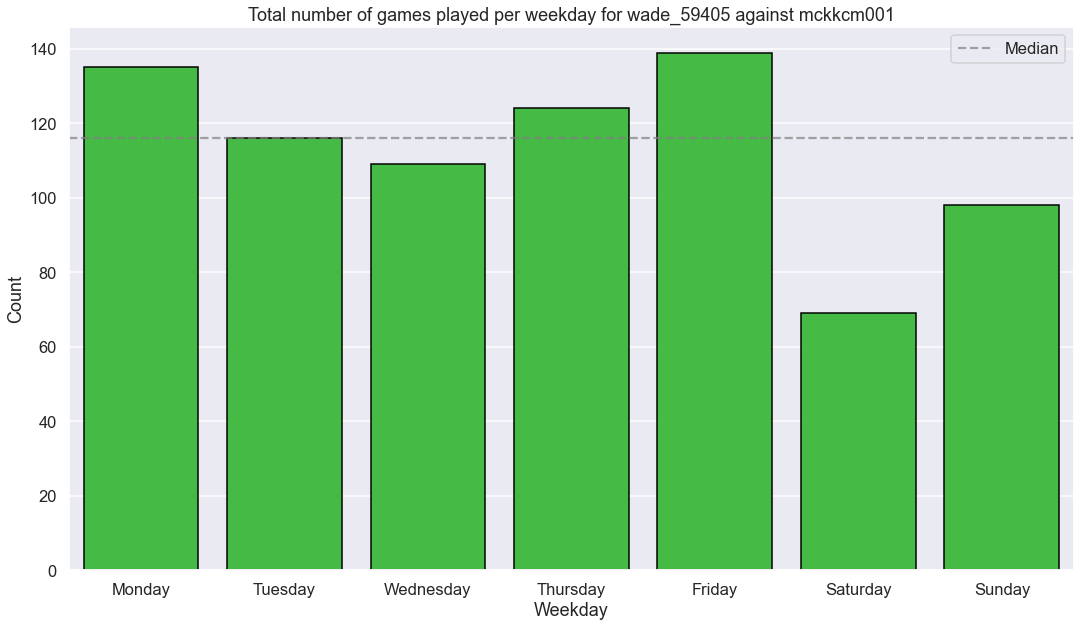

In [8]:
def plot_games_by_week_day(save_or_not : bool , title : str , df_=df):  
    ''' Create a count plot of the repartition of the game per weekday''' 
    
    df_['Date'] = pd.to_datetime(df_['Date'])
    df_['Day'] = df_['Date'].dt.weekday  
    day_df_ = df_.groupby('Day' , as_index=False)['Position'].count()
    days_ = ['Monday' , 'Tuesday' , 'Wednesday' , 'Thursday'  , 'Friday' , 'Saturday' , 'Sunday']
    day_df_['Day'] = days_
    day_df_.columns = ['Weekday' , 'Count']
    mean_ = np.median(day_df_['Count'].values)

    with sns.plotting_context('talk'):
        sns.set_style('darkgrid')
        plt.figure(figsize=(18,10))
        sns.barplot(data=day_df_ , x='Weekday' , y='Count' , color='limegreen' , edgecolor='black')
        plt.axhline(mean_ , color='grey' , linestyle='--' , alpha=0.7 , label='Median')
        plt.title(title)
        plt.legend()
        if save_or_not == True:
            plt.savefig(title ,  dpi=300, bbox_inches='tight')
        plt.show()

plot_games_by_week_day(save_or_not=True , title='Total number of games played per weekday for wade_59405 against mckkcm001' , df_=mck)

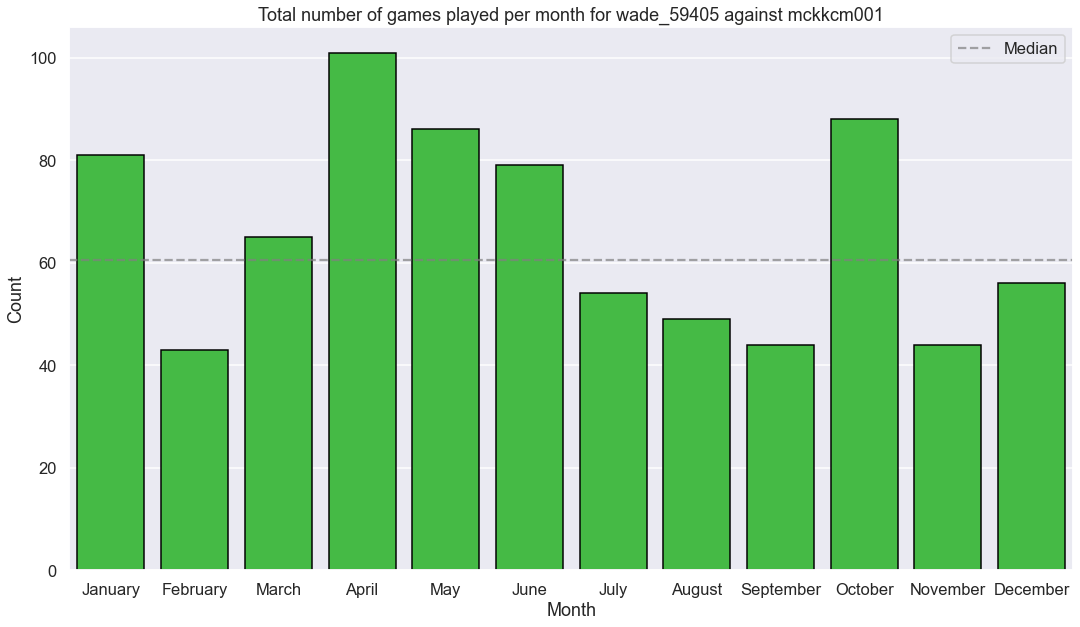

In [9]:
def plot_games_by_month(save_or_not : bool , title : str , df_=df , against_MaxGood = False):  
    ''' Create a count plot of the repartition of the game per month''' 
    
    df_['Date'] = pd.to_datetime(df_['Date'])
    df_['Month'] = df_['Date'].dt.month  
    month_df = df_.groupby('Month' , as_index=False)['Position'].count()
    if against_MaxGood == False:
        month_ = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    else:
        month_ = ['January', 'February', 'March', 'May',  'August', 'September' , 'December']

    month_df['Month'] = month_
    month_df.columns = ['Month' , 'Count']
    mean_ = np.median(month_df['Count'].values)

    with sns.plotting_context('talk'):
        sns.set_style('darkgrid')
        plt.figure(figsize=(18,10))
        sns.barplot(data=month_df , x='Month' , y='Count' , color='limegreen' , edgecolor='black')
        plt.axhline(mean_ , color='grey' , linestyle='--' , alpha=0.7 , label='Median')
        plt.title(title)
        plt.legend()
        if save_or_not == True:
            plt.savefig( title ,  dpi=300, bbox_inches='tight')
        plt.show()

plot_games_by_month(df_=mck , save_or_not=False , title='Total number of games played per month for wade_59405 against mckkcm001')

In [10]:
def plot_games_per_hour(save_or_not : bool , line_plot_ : bool , title : str , to_plot : pd.DataFrame , df_=df):
    ''' Plot the overall distribution of the games per hour (in moutains hours)'''

    to_plot['Hours'] = [f'{hour}:00' for hour in list(to_plot['Hours'])]
    with sns.plotting_context('talk'):
        sns.set_style('dark')
        fig , ax1= plt.subplots(figsize=(25,10))
        if line_plot_ == True:
            plt.plot(to_plot['Hours'] , to_plot['Count'] , color='limegreen')
        else:
            sns.barplot(to_plot['Hours'] , to_plot['Count'] , color='limegreen' , edgecolor='black')
        plt.axvline(3.6 , color='black' , alpha=0.5)
        plt.axvline(16.62 , color='black' , alpha=0.5)
        ax1.axvspan(3.6, 16.62, alpha=0.2, color='yellow' , label='Day')
        ax1.axvspan(3.6, 16.62,  color='grey' , label='Night' , alpha=0)
        #ax1.axvspan(15.4, 18, alpha=0.2, color='black')
        plt.ylabel('Count')
        plt.xlabel('Time of the day')
        plt.legend(edgecolor='black')
        plt.title(title)
        if save_or_not == True:
            plt.savefig(title ,  dpi=300, bbox_inches='tight')
        plt.show()

def remove_extreme_hours(to_plot : pd.DataFrame): return to_plot[(to_plot['Hours'] >= 4) & (to_plot['Hours'] <= 22)]

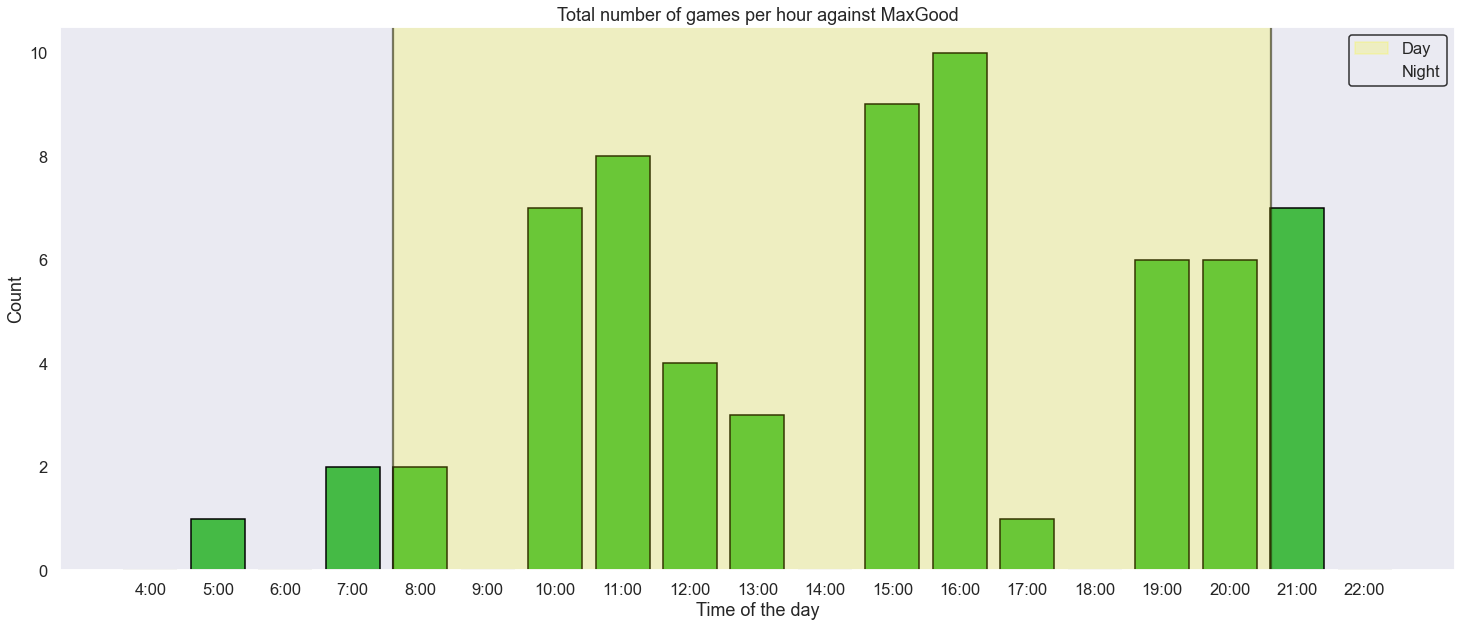

In [18]:
to_plot_df = df.groupby('moutain_hour' , as_index=False)['Position'].count()
to_plot_df.columns = ['Hours' , 'Count']
hours_df = to_plot_df.Hours.values

to_plot_max = max_.groupby('moutain_hour' , as_index=False)['Position'].count()
to_plot_max.columns = ['Hours' , 'Count']
hours_max = to_plot_max.Hours.values

to_plot_mck = mck.groupby('moutain_hour' , as_index=False)['Position'].count()
to_plot_mck.columns = ['Hours' , 'Count']
hours_mck = to_plot_mck.Hours.values


count_max , count_mck = [] , []
for val in hours_df:
    if val in list(to_plot_max['Hours']):
        count_max.append(int(to_plot_max[to_plot_max['Hours'] == val]['Count']))
    else:
        count_max.append(0)

for val in hours_df:
    if val in list(to_plot_mck['Hours']):
        count_mck.append(int(to_plot_mck[to_plot_mck['Hours'] == val]['Count']))
    else:
        count_mck.append(0)

to_plot_max = pd.DataFrame({'Hours' : hours_df , 'Count' : count_max})
to_plot_mck = pd.DataFrame({'Hours' : hours_df , 'Count' : count_mck})

plot_games_per_hour(save_or_not=False , line_plot_=False , title='Total number of games per hour against MaxGood' , to_plot=remove_extreme_hours(to_plot_max))

## Bonus : Per year + evolution of elo over time

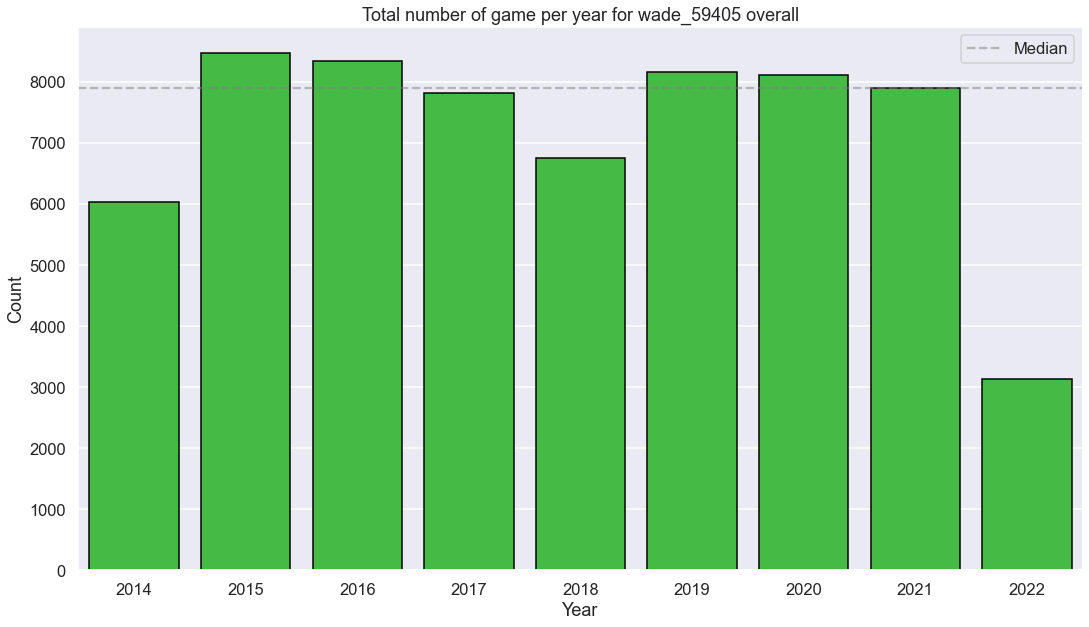

In [12]:
def plot_games_by_year(to_save_or_not : bool , title : str , df_=df):
    '''Plot the distribution of games per year'''
    
    df_['Date'] = pd.to_datetime(df_['Date'])
    df_['Year'] = df_['Date'].dt.year 
    to_plot = df_.groupby('Year' , as_index=False)['Position'].count()
    to_plot.columns = ['Year' , 'Count']
    median_ = np.median(to_plot['Count'].values)
    with sns.plotting_context('talk'):
        plt.figure(figsize=(18,10))
        sns.set_style('darkgrid')
        sns.barplot(data=to_plot , x='Year' , y='Count' , color='limegreen' , edgecolor='black')
        plt.axhline(median_ , color='grey' , alpha=0.5 , linestyle='--' , label='Median')
        plt.legend()
        plt.title(title)
        if to_save_or_not == True:
            plt.savefig(title ,  dpi=300, bbox_inches='tight')
        plt.show()


plot_games_by_year(False , title='Total number of game per year for wade_59405 overall' , df_=df)



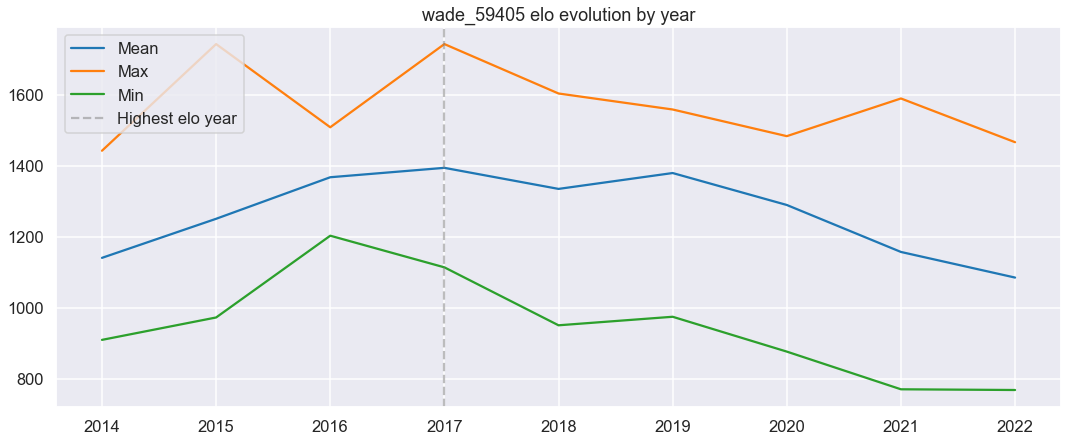

In [13]:
def plot_elo_evolution(save_or_not : bool , df=df):
    ''' Snake plot of the elo evolution of wade_59405 across the years '''

    liste_tc = [' 120+1' , ' 180+2' , ' 300' , ' 180' , ' 600'] # For consistency
    #df = df[df['Time_control'].isin(liste_tc)]

    wade_elo = []
    for i in range(len(df)):
        if df.iloc[i]['White'] == 'wade_59405':
            wade_elo.append(int(df.iloc[i]['White_elo']))
        else:
            wade_elo.append(int(df.iloc[i]['Black_elo']))

    df['wade_elo'] = wade_elo 
    with sns.plotting_context('talk'):
        plt.figure(figsize=(18,7))
        to_plot_mean = df.groupby('Year' , as_index=False)['wade_elo'].mean()
        to_plot_max = df.groupby('Year' , as_index=False)['wade_elo'].max()
        to_plot_min = df.groupby('Year' , as_index=False)['wade_elo'].min()

        plt.plot(to_plot_mean['Year'] , to_plot_mean['wade_elo'] , label='Mean')
        plt.plot(to_plot_max['Year'] , to_plot_max['wade_elo'] , label='Max')
        plt.plot(to_plot_min['Year'] , to_plot_min['wade_elo'] , label='Min')
        plt.axvline(2017 , color='grey' , alpha=0.5 , linestyle='--' , label='Highest elo year')
        plt.legend(loc='upper left')
        plt.title('wade_59405 elo evolution by year')
        if save_or_not == True:
            plt.savefig('wade_59405 elo evolution by year' , dpi=300, bbox_inches='tight')
        plt.show()

plot_elo_evolution(save_or_not=False)

## Scraping 
Find the games where wade_59405 performed brilliant moves.

In [14]:
def find_games_with_brilliant_moves(username : str , password : str , display_page=True , df_=df):
    ''' Iterate over the games to find the game where wade_59405 performed brilliant moves. 
        This function use selenium , log in to the chess.com website , and run the analysis at each iteration. 
        It's very time consuming , but the link and number of brillant move per game are displayed to the screen as the function goes 
        , so you can check the interesting games at the same time. 
         Returns a dataframe with only the games where wade_59405 performed brilliant moves. '''
    

    ##### Constants #####
    if display_page == False:
        options = Options()
        options.headless = True # To not display the page
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()) , options=options) 
    else:
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install())) 

    pattern = re.compile('tallies-hoverable">(.*?)</div>')
    n_white_bm , n_black_bm = [] , [] 


    ##### Log in #####
    driver.get('https://www.chess.com/')
    time.sleep(1)
    driver.find_element(By.XPATH , ('//*[@id="sb"]/div[3]/a[9]/span[1]')).click()
    time.sleep(1)
    user_name = driver.find_element(By.XPATH , ('//*[@id="username"]'))
    pass_word = driver.find_element(By.XPATH , ('//*[@id="password"]'))
    user_name.send_keys(username)
    pass_word.send_keys(password)
    driver.find_element(By.XPATH , ('//*[@id="login"]')).click() # Log in
    time.sleep(1)


    ##### Main loop ##### 
    for link in list(df_['Link']):
        link = f"{str(link).replace('/game/' , '/analysis/game/')}?tab=review"
        driver.get(link)
        time.sleep(7) # Time needed for the chess.com engine to perform the analysis
        source_code = driver.page_source 
        soup = BeautifulSoup(source_code)
        brillant = soup.find('div' , {'data-cy':"tallies-row-Brilliant"}) # If you replace 'Brilliant' by , let's say 'Excellent' , it will find the excellents number of moves
        brilliant_moves = re.findall(pattern=pattern , string=str(brillant))
        
        if brilliant_moves == []:
                time.sleep(1)
                try:
                    driver.find_element(By.XPATH , ('//*[@id="board-layout-chessboard"]/div[2]/div[3]/div[2]/div/div/button/div')).click() # Close the windows where the little guys try to sell me a suscription
                except:
                    time.sleep(1)
                    
                brillant = soup.find('div' , {'data-cy':"tallies-row-Brilliant"}) 
                brilliant_moves = re.findall(pattern=pattern , string=str(brillant))

        print('Current game : ' , link)
        if brilliant_moves[0] != '0' or brilliant_moves[1] != '0':
            print('Number of brillant moves in this game : ' , brilliant_moves)
        else:
            print('Nothing interesting in this game.')

        for i in range(2):
            string = brilliant_moves[i]
            for val in string:
                if str(val).isdigit() or val == '?': # If , like me , you don't have a suscription , the brilliant and great moves will be '?'
                    if i == 0:
                        n_white_bm.append(val)
                    else:
                        n_black_bm.append(val)
        time.sleep(1)                

    ##### Process the outputs #####
    assert len(n_white_bm) == len(n_black_bm) == len(df_)
    df_['n_white_bm'] , df_['n_black_bm'] = n_white_bm , n_black_bm
    gw = df_[(df_['White'] == 'wade_59405') & (df_['n_white_bm'] != '0')]
    gb = df_[(df_['Black'] == 'wade_59405') & (df_['n_black_bm'] != '0')]
    to_return = pd.concat([gw , gb])

    return to_return